In [74]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Part A: Data preprocessing and feature engineering

In [75]:
df_Trans=pd.read_csv(r"./HI-Small_Trans.csv")
df_Banks=pd.read_csv(r"./HI-Small_accounts.csv")

In [76]:
data=df_Trans.copy()
details=df_Banks.copy()
del df_Trans,df_Banks

# Data Exploration

In [77]:
data.shape

(5078345, 11)

In [78]:
data.head(2)

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0


In [79]:
details.head(2)

,Bank Name,Bank ID,Account Number,Entity ID,Entity Name
0,Portugal Bank #4507,331579,80B779D80,80062E240,Sole Proprietorship #50438
1,Canada Bank #27,210,809D86900,800C998A0,Corporation #33520


In [80]:
data['Timestamp']= pd.to_datetime(data['Timestamp'], format='%Y/%m/%d %H:%M')

In [81]:
data.head(2)

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0


### show imbalanced

In [82]:
data["Is Laundering"].value_counts(normalize=True)*100

Is Laundering
0    99.898057
1     0.101943
Name: proportion, dtype: float64

### clean

In [83]:
# Check for null values in each column
null_values = data.isnull().sum()

# Check for number of duplicate rows
num_duplicates = data.duplicated().sum()

# Print results
print("Null Values in Each Column:\n", null_values)
print("\nNumber of Duplicate Rows:", num_duplicates)

Null Values in Each Column:
 Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64

Number of Duplicate Rows: 9


In [84]:
# 'keep=False' marks all duplicates as True, showing all copies
duplicate_rows = data[data.duplicated(keep=False)]

# Sort them to group the identical rows together
print(duplicate_rows.sort_values(by=list(duplicate_rows.columns)))

                  Timestamp  From Bank    Account  To Bank  Account.1  \
863294  2022-09-01 16:20:00      12004  800C927C1      220  813D8C1E1   
863296  2022-09-01 16:20:00      12004  800C927C1      220  813D8C1E1   
863293  2022-09-01 16:20:00      12004  800C927C1    12004  800C927C0   
863295  2022-09-01 16:20:00      12004  800C927C1    12004  800C927C0   
3684003 2022-09-07 21:25:00      29992  8099A29B1      220  813725AE1   
3684005 2022-09-07 21:25:00      29992  8099A29B1      220  813725AE1   
4166785 2022-09-08 21:05:00     113779  811144AB1    53744  813C777F1   
4166787 2022-09-08 21:05:00     113779  811144AB1    53744  813C777F1   
4166784 2022-09-08 21:05:00     113779  811144AB1   113779  811144AB0   
4166786 2022-09-08 21:05:00     113779  811144AB1   113779  811144AB0   
4510478 2022-09-09 10:03:00       6075  80C702911     6075  80C702910   
4510480 2022-09-09 10:03:00       6075  80C702911     6075  80C702910   
4510479 2022-09-09 10:03:00       6075  80C702911  

In [85]:
# found 8 exact duplicate  rows
data.drop_duplicates(inplace=True)

In [86]:
data.shape

(5078336, 11)

In [87]:
# Removing those banks where no Laundering occured
counts =data.groupby(['From Bank', 'Is Laundering']).size().unstack(fill_value=0)
banks_no_laundering = counts.loc[counts.get(1, 0) == 0].index.tolist()
print(f"(Removed)Banks with no laundering cases: {len(banks_no_laundering)}")
data = data[~data['From Bank'].isin(banks_no_laundering)]

(Removed)Banks with no laundering cases: 29449


In [88]:
data["Is Laundering"].value_counts(normalize=True)*100

Is Laundering
0    99.885924
1     0.114076
Name: proportion, dtype: float64

### feature engineering

### deal with time

In [89]:
data['weekday'] = data['Timestamp'].dt.weekday
data['hour'] = data['Timestamp'].dt.hour

In [90]:
# If sender is same as reciever then self else out 
data['Type'] = np.where(data['Account'] == data['Account.1'],'self', 'out')

In [91]:
# keeping a count of transactions done over the period by each account
data = data.sort_values('Timestamp')
data['sender_txn_overall_count'] = data.groupby('Account').cumcount() + 1
data['reciever_txn_overall_count'] = data.groupby('Account.1').cumcount() + 1

# keeping a count of transactions done daily by each account
data['sender_txn_daily_count'] = data.groupby(['Account','weekday']).cumcount() + 1
data['reciever_txn_daily_count'] = data.groupby(['Account.1','weekday']).cumcount() + 1

In [92]:
# cleaning the bank details
details['Entity Name']=details['Entity Name'].str.split(' #').str[0]
details['Bank Name']=details['Bank Name'].str.split(' #').str[0]

In [93]:
# Merging data and details
newdf=pd.merge(data,details,left_on='Account',right_on='Account Number')
newdf.drop(columns=['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1','Bank ID','Account Number','Entity ID'],inplace=True)


In [94]:
data.tail(5)

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,weekday,hour,Type,sender_txn_overall_count,reciever_txn_overall_count,sender_txn_daily_count,reciever_txn_daily_count
4962230,2022-09-18 10:02:00,9371,8043A0FB0,16163,802F78670,3749.14,US Dollar,3749.14,US Dollar,ACH,1,6,10,out,43,42,2,1
4962231,2022-09-18 11:18:00,9371,8043A0FB0,9371,8043A0FB0,1785.27,Euro,2091.95,US Dollar,ACH,0,6,11,self,44,40,3,4
4962232,2022-09-18 11:18:00,9371,8043A0FB0,13858,8095526B0,1785.27,Euro,1785.27,Euro,ACH,1,6,11,out,45,2,4,1
4962233,2022-09-18 12:58:00,9371,8043A0FB0,1124,8026687E0,2154.54,US Dollar,2154.54,US Dollar,ACH,1,6,12,out,46,4,5,1
4962234,2022-09-18 16:18:00,9371,8043A0FB0,4503,809320130,5448.55,US Dollar,5448.55,US Dollar,ACH,1,6,16,out,47,45,6,3


# PartB: Pipeline for transformations

In [95]:
# numerical
numerical_cols = newdf.select_dtypes(include=np.number).drop(['Is Laundering','weekday','hour'], axis=1).columns.tolist()
# one hot encoding columns 
OHE_cols =['Receiving Currency','Payment Currency','Payment Format','Type','Entity Name','weekday','hour']
# binned columns (binary encoding will be used due to high cardinality)
Bin_cols=['Bank Name']

In [96]:
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce

def create_preprocessor(numerical_cols,OHE_cols,Bin_cols):
    numeric_transformer = SklearnPipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),                                    # impute missing values with mean
        ('scaler', StandardScaler())                                                    # standardize numerical features
    ])
    categorical_transformer1 = SklearnPipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),                           # impute missing values with mode
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))         # one-hot encode categorical if features sees a new category during prediction
        #('Label', OrdinalEncoder())
    ])
    categorical_transformer2 = SklearnPipeline(steps=[                                  # Bin_cols
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('binary_enc', ce.BinaryEncoder(drop_invariant=True   ))])                      # binary encoding for high cardinality categorical features
        
    preprocessor = ColumnTransformer(                                                   # combine all transformers            
        transformers=[                              
            ('num', numeric_transformer, numerical_cols),                                   
            ('cat1', categorical_transformer1, OHE_cols),                 
            ('cat2', categorical_transformer2, Bin_cols)
        ], remainder='drop'                                                             # keep other columns droppped
    )
    return preprocessor

In [97]:
preproc=create_preprocessor(numerical_cols, OHE_cols, Bin_cols)

In [98]:
X_transformed = preproc.fit_transform(newdf.drop('Is Laundering', axis=1))

In [99]:
X_transformed.shape

(4538231, 91)

# PartC: Oversampling(SMOTE)

split data and fix imbalanced dataset by creating new, synthetic data points for the minority class.

In [100]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_transformed, newdf['Is Laundering'],train_size=0.7)

In [101]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(k_neighbors=5)                     

X_train_smote,y_train_smote=smote.fit_resample(X_train,y_train)

Original class distribution:
Is Laundering
0    3173150
1       3611
Name: count, dtype: int64

Resampled class distribution:
Is Laundering
0    3173150
1    3173150
Name: count, dtype: int64


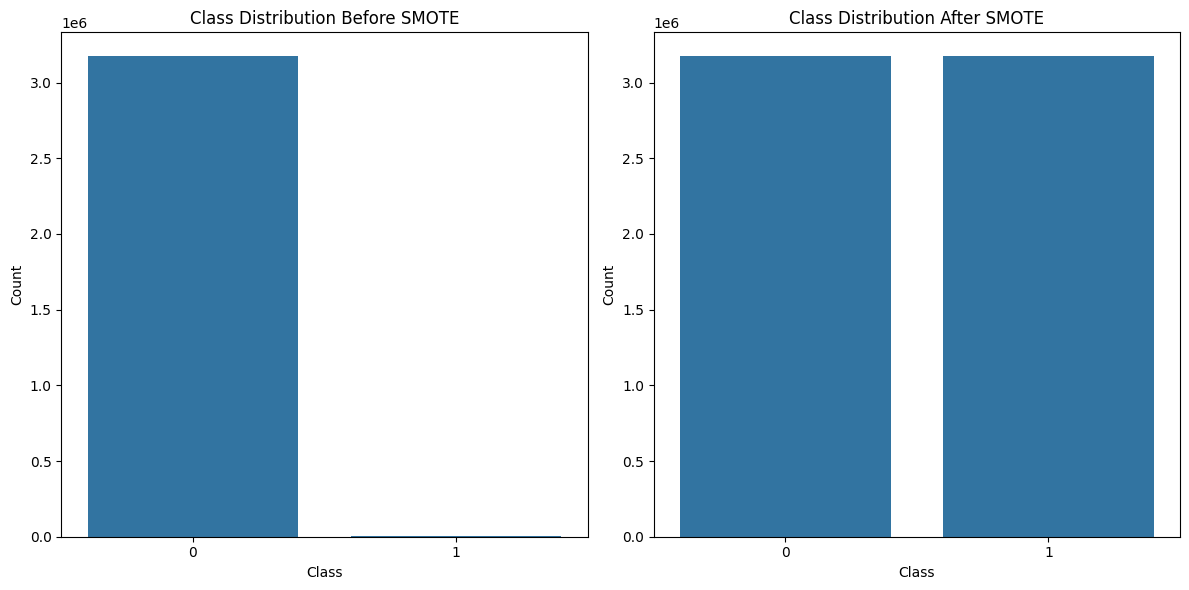

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

print(f"Original class distribution:\n{pd.Series(y_train).value_counts()}")
print(f"\nResampled class distribution:\n{pd.Series(y_train_smote).value_counts()}")

# Create a figure with two subplots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Class distribution BEFORE SMOTE
sns.countplot(x=y_train, ax=ax1)
ax1.set_title('Class Distribution Before SMOTE')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')

# Plot 2: Class distribution AFTER SMOTE
sns.countplot(x=y_train_smote, ax=ax2)
ax2.set_title('Class Distribution After SMOTE')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')

# Show the plot
plt.tight_layout()
plt.show()

# Or save it to a file
# plt.savefig('smote_comparison.png')

# PartD: MODEL

In [103]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Convert the data into DMatrix, which is highly efficient data structure used internally by the XGBoost library.
dtrain = xgb.DMatrix(X_train_smote, label=y_train_smote)
dtest = xgb.DMatrix(X_test, label=y_test)

[0]	train-logloss:0.61100	train-error:0.04972	test-logloss:0.61144	test-error:0.09755
[1]	train-logloss:0.53865	train-error:0.02063	test-logloss:0.53975	test-error:0.03236
[1]	train-logloss:0.53865	train-error:0.02063	test-logloss:0.53975	test-error:0.03236
[2]	train-logloss:0.47800	train-error:0.02042	test-logloss:0.47982	test-error:0.03922
[2]	train-logloss:0.47800	train-error:0.02042	test-logloss:0.47982	test-error:0.03922
[3]	train-logloss:0.42673	train-error:0.01780	test-logloss:0.42936	test-error:0.03399
[3]	train-logloss:0.42673	train-error:0.01780	test-logloss:0.42936	test-error:0.03399
[4]	train-logloss:0.38252	train-error:0.01788	test-logloss:0.38576	test-error:0.03388
[4]	train-logloss:0.38252	train-error:0.01788	test-logloss:0.38576	test-error:0.03388
[5]	train-logloss:0.34507	train-error:0.01625	test-logloss:0.34876	test-error:0.03097
[5]	train-logloss:0.34507	train-error:0.01625	test-logloss:0.34876	test-error:0.03097
[6]	train-logloss:0.31195	train-error:0.01458	test-log

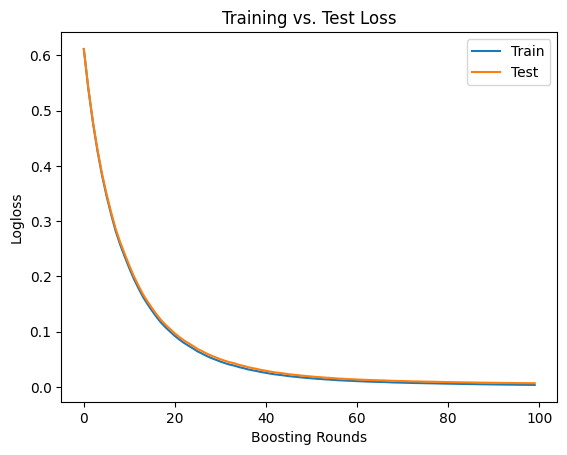

In [104]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error'],
    'eta': 0.1,
    'max_depth': 16,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1,
    'lambda': 1
}

# Train the XGBoost model and record the evaluation results
num_rounds = 100
watchlist = [(dtrain, 'train'), (dtest, 'test')]
eval_results = {}
bst = xgb.train(params, dtrain, num_rounds, evals=watchlist, evals_result=eval_results)



# Extract the training loss from the evaluation results
train_loss = eval_results['train']['logloss']

# (นี่คือโค้ดส่วนสุดท้ายของคุณ)

# Extract the training *AND* test loss from the evaluation results
train_loss = eval_results['train']['logloss']
test_loss = eval_results['test']['logloss']  # <-- เพิ่มบรรทัดนี้

# Plot the training *AND* test loss curve
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')    # <-- เพิ่มบรรทัดนี้
plt.title('Training vs. Test Loss')
plt.ylabel('Logloss')
plt.xlabel('Boosting Rounds')
plt.legend()
plt.show()
plt.show()

# PartE: Evalution and confusion matrix

Confusion Matrix

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    roc_auc_score, 
    roc_curve
)

def evaluate_fraud_detection_model(model, dtest, y_test, threshold=0.5):
    """
    Evaluate the fraud detection model, focusing on TPR and visualization.
    (Assumes a 'bst' model trained from xgb.train)
    """
    
    # --- 1. Make Predictions ---
    # model.predict(dtest) will give probabilities
    y_pred_probs = model.predict(dtest) 
    y_pred_labels = (y_pred_probs > threshold).astype(int)
    
    # --- 2. Classification Report ---
    print("=" * 60)
    print(f"CLASSIFICATION REPORT (at Threshold = {threshold})")
    print("=" * 60)
    report = classification_report(y_test, y_pred_labels, output_dict=True, zero_division=0)
    print(classification_report(y_test, y_pred_labels, zero_division=0))
    
    # --- 3. Extract Key Metrics (Class 1: Fraud) ---
    if '1' in report:
        tpr = report['1']['recall']
        precision = report['1']['precision']
        f1 = report['1']['f1-score']
        
        print(f"\n{'=' * 60}")
        print("KEY METRICS FOR FRAUD DETECTION (Class 1)")
        print("=" * 60)
        print(f"TPR (Recall):       {tpr:.4f} - Detects Fraud cases")
        print(f"Precision:          {precision:.4f} - Accuracy of Fraud predictions")
        print(f"F1-Score:           {f1:.4f} - Harmonic mean of Precision & Recall")
    else:
        print("\n*** No '1' (Fraud) cases were predicted ***")
        tpr, precision, f1 = 0, 0, 0
    
    # --- 4. Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred_labels)
    tn, fp, fn, tp = 0, 0, 0, 0 # Initial values
    
    # Handle different shapes of confusion matrix (e.g., if only one class is predicted)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    elif cm.shape == (1, 1):
        if y_test.nunique() == 1: # If y_test has only one class
            if y_test.iloc[0] == 0: tn = cm[0,0]
            else: tp = cm[0,0]
        else: # Strange case
            print("Warning: Problem with Confusion Matrix shape")
    else: # Handle partial cases
        labels_in_y = set(y_test)
        if 0 in labels_in_y:
            tn = cm[0,0]
            if 1 in labels_in_y:
                fn = cm[1,0]
                if cm.shape[1] > 1: # Predictions for 1 exist
                    fp = cm[0,1]
                    tp = cm[1,1]
            else: # y_test only has 0
                if cm.shape[1] > 1: fp = cm[0,1]
        elif 1 in labels_in_y: # y_test only has 1
            tp = cm[0,0]
            if cm.shape[1] > 1: fn = cm[0,1] # Predicted 0 but was 1


    print(f"\n{'=' * 60}")
    print("CONFUSION MATRIX BREAKDOWN")
    print("=" * 60)
    print(f"True Negatives:   {tn:,} - (Normal) Predicted (Normal) [Correct]")
    print(f"False Positives:  {fp:,} - (Normal) Predicted (Fraud) [False Alarm ⚠️]")
    print(f"False Negatives:  {fn:,} - (Fraud) Predicted (Normal) [Missed Detection ⚠️]")
    print(f"True Positives:   {tp:,} - (Fraud) Predicted (Fraud) [Correct]")
    
    if (tp + fn) > 0:
        print(f"\nTPR (Verification): {tp / (tp + fn):.4f}")
    
    # --- 5. ROC AUC ---
    auc = roc_auc_score(y_test, y_pred_probs)
    fpr_curve, tpr_curve, thresholds = roc_curve(y_test, y_pred_probs)
    
    # Find the point on the curve corresponding to the current threshold
    # Use np.searchsorted for efficiency, or find closest value
    try:
        threshold_idx = np.argmin(np.abs(thresholds - threshold))
    except (ValueError, IndexError):
        threshold_idx = 0 # Default if something goes wrong
        
    current_fpr = fpr_curve[threshold_idx]
    current_tpr = tpr_curve[threshold_idx]
    
    # --- 6. Plot Graphs ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues', 
                xticklabels=['Normal (0)', 'Fraud (1)'],
                yticklabels=['Normal (0)', 'Fraud (1)'],
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title(f'Confusion Matrix\n(Threshold: {threshold})', 
                        fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Actual Label', fontsize=11)
    axes[0].set_xlabel('Predicted Label', fontsize=11)
    
    # Plot 2: ROC Curve
    axes[1].plot(fpr_curve, tpr_curve, linewidth=2.5, 
                 label=f'Model (AUC = {auc:.4f})')
    axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1.5, 
                 label='Random Classifier (AUC = 0.5)')
    axes[1].scatter(current_fpr, current_tpr, color='red', s=150, 
                    zorder=5, edgecolors='black', linewidth=1.5,
                    label=f'Current Threshold ({threshold})')
    axes[1].set_xlabel('False Positive Rate (FPR)', fontsize=11)
    axes[1].set_ylabel('True Positive Rate (TPR)', fontsize=11)
    axes[1].set_title('ROC Curve - Model Performance', 
                        fontsize=12, fontweight='bold')
    axes[1].legend(loc='lower right', fontsize=9)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim([-0.02, 1.02])
    axes[1].set_ylim([-0.02, 1.02])
    
    plt.tight_layout()
    plt.show()
    
    return { 'tpr': tpr, 'precision': precision, 'f1_score': f1, 'auc': auc }

def find_optimal_threshold(model, dtest, y_test, min_precision=0.1):
    """
    Find the threshold that gives the highest TPR (Recall)
    while ensuring Precision is not lower than the specified min_precision.
    """
    y_pred_probs = model.predict(dtest)
    
    best_threshold = 0
    best_tpr = 0
    best_precision = 0
    
    # Loop through a range of thresholds
    for thresh in np.linspace(0.01, 1.0, 100):
        y_pred = (y_pred_probs > thresh).astype(int)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        
        if '1' in report:
            prec = report['1']['precision']
            rec = report['1']['recall'] # (TPR)
            
            # If Precision meets the criteria and Recall (TPR) is better than the current best
            if prec >= min_precision and rec > best_tpr:
                best_tpr = rec
                best_precision = prec
                best_threshold = thresh
    
    print(f"\n{'=' * 60}")
    print("OPTIMAL THRESHOLD SEARCH")
    print("=" * 60)
    print(f"Condition: Precision must be >= {min_precision:.2f}")
    if best_tpr > 0:
        print(f"Found Best Threshold: {best_threshold:.4f}")
        print(f"   -> Precision: {best_precision:.4f}")
        print(f"   -> TPR (Recall): {best_tpr:.4f}")
    else:
        print(f"Could not find a threshold with Precision >= {min_precision:.2f}")
        
    return best_threshold

 Threshold 0.5 ---
CLASSIFICATION REPORT (at Threshold = 0.5)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1359904
           1       0.34      0.25      0.29      1566

    accuracy                           1.00   1361470
   macro avg       0.67      0.63      0.65   1361470
weighted avg       1.00      1.00      1.00   1361470


KEY METRICS FOR FRAUD DETECTION (Class 1)
TPR (Recall):       0.2548 - Detects Fraud cases
Precision:          0.3431 - Accuracy of Fraud predictions
F1-Score:           0.2924 - Harmonic mean of Precision & Recall

CONFUSION MATRIX BREAKDOWN
True Negatives:   1,359,140 - (Normal) Predicted (Normal) [Correct]
False Positives:  764 - (Normal) Predicted (Fraud) [False Alarm ⚠️]
False Negatives:  1,167 - (Fraud) Predicted (Normal) [Missed Detection ⚠️]
True Positives:   399 - (Fraud) Predicted (Fraud) [Correct]

TPR (Verification): 0.2548
              precision    recall  f1-score   support

           0 

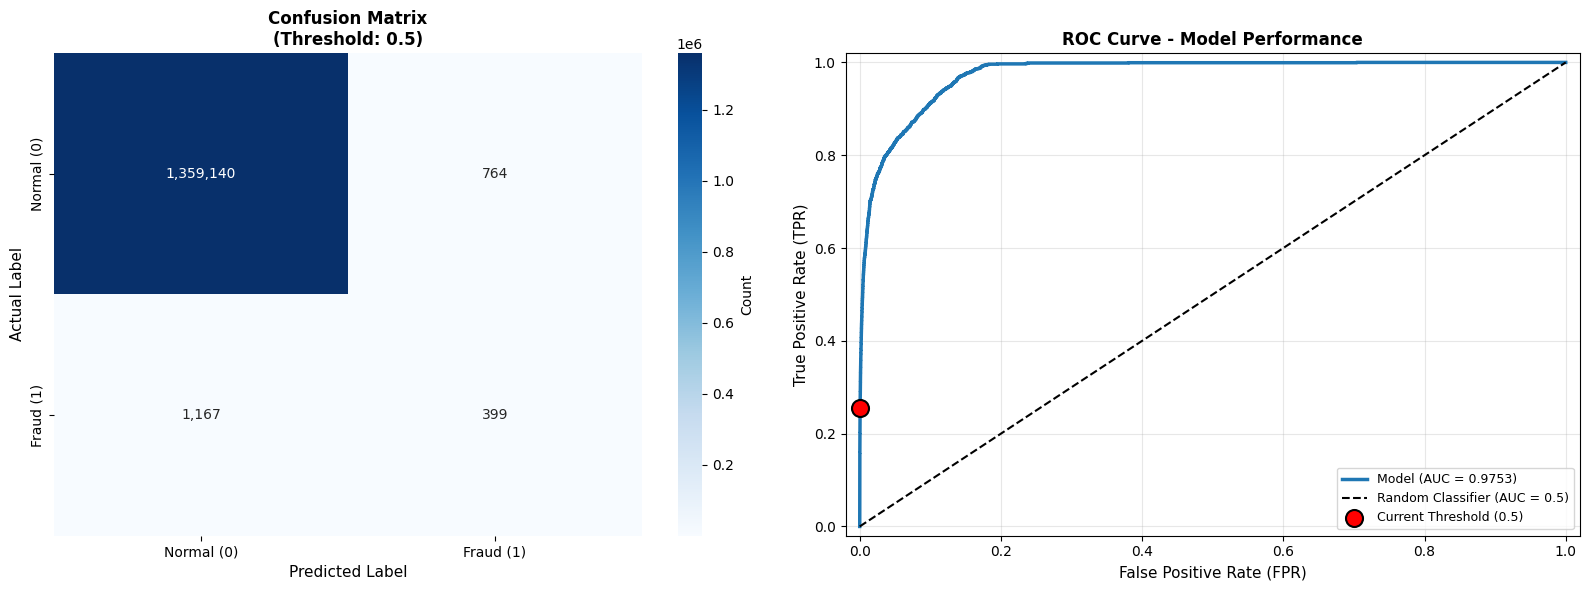


OPTIMAL THRESHOLD SEARCH
Condition: Precision must be >= 0.10
Found Best Threshold: 0.1100
   -> Precision: 0.1010
   -> TPR (Recall): 0.5562

--- Optimal Threshold ---
CLASSIFICATION REPORT (at Threshold = 0.11)
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1359904
           1       0.10      0.56      0.17      1566

    accuracy                           0.99   1361470
   macro avg       0.55      0.78      0.58   1361470
weighted avg       1.00      0.99      1.00   1361470


KEY METRICS FOR FRAUD DETECTION (Class 1)
TPR (Recall):       0.5562 - Detects Fraud cases
Precision:          0.1010 - Accuracy of Fraud predictions
F1-Score:           0.1709 - Harmonic mean of Precision & Recall

CONFUSION MATRIX BREAKDOWN
True Negatives:   1,352,148 - (Normal) Predicted (Normal) [Correct]
False Positives:  7,756 - (Normal) Predicted (Fraud) [False Alarm ⚠️]
False Negatives:  695 - (Fraud) Predicted (Normal) [Missed Detection ⚠️]
True

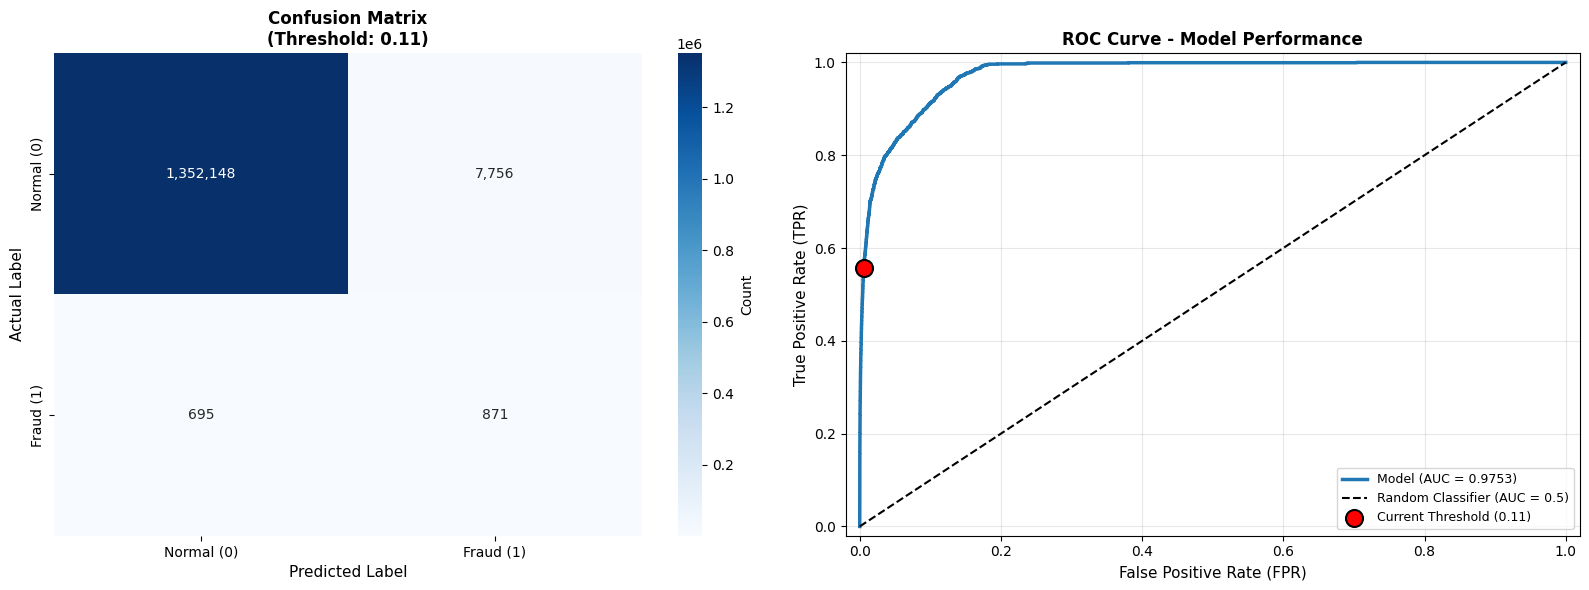

In [108]:
# --- (นี่คือโค้ดประเมินผลที่ถูกต้อง) ---

# 1. ประเมินผลที่ Threshold 0.5 (เพื่อดูปัญหา)
#    เราใช้ 'bst' (โมเดลของคุณ), 'dtest' (ข้อมูลทดสอบของคุณ),
#    และ 'y_test' (เลเบลจริงของข้อมูลทดสอบ)
print(" Threshold 0.5 ---")
metrics_0_5 = evaluate_fraud_detection_model(bst, dtest, y_test, threshold=0.5)

# 2. ค้นหา Threshold ที่ดีที่สุด
#    (เช่น ลองหาจุดที่ Precision อย่างน้อย 10% หรือ 0.1)
best_thresh = find_optimal_threshold(bst, dtest, y_test, min_precision=0.1) 

# 3. ประเมินผลอีกครั้งด้วย Threshold ใหม่
if best_thresh > 0:
    print("\n--- Optimal Threshold ---")
    metrics_new = evaluate_fraud_detection_model(bst, dtest, y_test, threshold=best_thresh)
else:
    print("\n no better Threshold ")